# Imports

In [1]:
import sys
sys.path.append('..')

In [148]:
# analysis
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# local
import alignment.alignment_utils as utils
from alignment.AlignCCA import AlignCCA
from alignment.alignment_utils import cnd_avg

%matplotlib inline

# Data Loading

### Real data

In [3]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [4]:
DATA_PATH = '../data/'
data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl' # mean-subtracted
# data_filename = DATA_PATH + 'pt_decoding_data_S62_zscore.pkl' # z-scored

In [5]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [6]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [7]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

## Phoneme label processing functions

In [8]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [9]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [10]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [11]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

# Data Visualization

### Plotting utils

In [12]:
px_colors = [
             '#636EFA',
             '#FFA15A',
             '#EF553B',
             '#00CC96',
            #  '#72B7B2',
            #  '#990099',
            #  '#B6E880',

             
            #  '#FFA15A',
            #  '#19D3F3',
            #  '#FF6692',
            #  '#B6E880',
            #  '#FF97FF',
            #  '#FECB52',
            ]

In [13]:
# sns.set_theme(context='notebook', font='Arial', font_scale=1.15)
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [14]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [16]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [17]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

### Panel a

In [ ]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_chans = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_chans.append(np.where(~np.isnan(d)[0,0,:])[0])
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)

In [ ]:
def get_pt_map_from_flat(pt):
    if pt in ['S14', 'S22']:
        chan_map = np.arange(128).reshape(8,16).T+1
    elif pt in ['S23', 'S26']:
        chan_map = np.flipud(np.arange(128).reshape(8,16).T)+1
    elif pt == 'S33':
        chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    elif pt == 'S39':
        chan_map = np.arange(288).reshape(24,12).T+1
    else:
        chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
    return chan_map

In [ ]:
pt = 'S14' # S1 in paper
pt_ind = pt_names.index(pt)
cnd_labels = all_pt_artic_labels[pt]; lab_names = artic_labels
data_avg = cnd_avg(all_pt_elec_data[pt_ind], cnd_labels)
chan_map = get_pt_map_from_flat(pt)

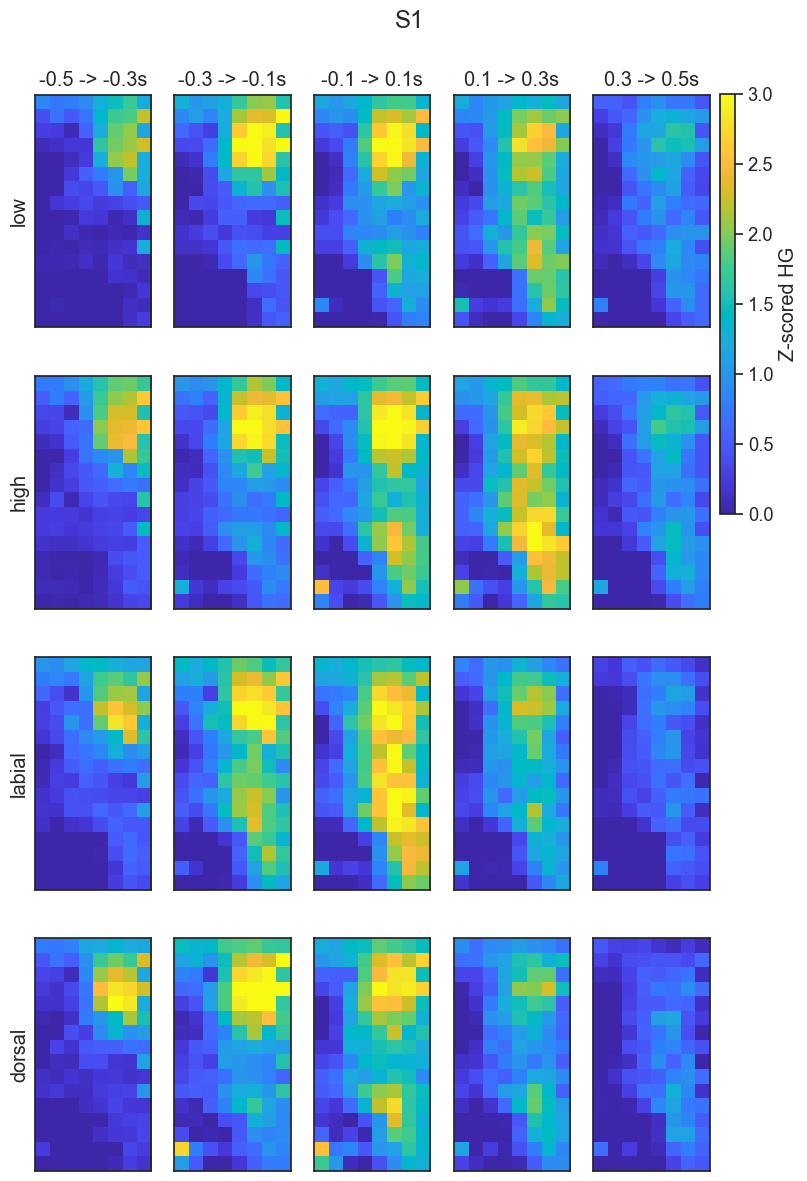

In [ ]:
t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

figsize=(2,3.5)
cbar_pos = [0.81, 0.58, 0.015, 0.3]
sup_pos = 0.94
chan_disp_seq(data_avg, chan_map, t, t_ranges, lab_names, 'S1', 'Z-scored HG', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos, cbar_lower=0, cbar_upper=3)

In [ ]:
wide_dfs = []
long_dfs = []
for pt in pt_names:
    n_comp = 0.9

    curr_trace = all_pt_traces[pt]

    d = cnd_avg(curr_trace, all_pt_artic_labels[pt]) # (n_artics, time, channels)
    d = np.transpose(d, axes=(2,1,0)) # (channels, time, n_artics)
    n_ch = d.shape[0]
    d = d.reshape(-1, d.shape[-1]) # (channels*time, n_artics)

    hg_artic_df_wide = pd.DataFrame(d, columns=artic_labels)
    hg_artic_df_wide['Time'] = np.tile(t, n_ch)
    hg_artic_df_wide['Patient'] = [paper_pt_dict[pt]] * d.shape[0]

    hg_artic_df_long = hg_artic_df_wide.melt(id_vars=['Time', 'Patient'], var_name='Articulator Type', value_name='Z-scored HG')

    
    wide_dfs.append(hg_artic_df_wide)
    long_dfs.append(hg_artic_df_long)

hg_artic_df_wide = pd.concat(wide_dfs, ignore_index=True)
hg_artic_df_long = pd.concat(long_dfs, ignore_index=True)

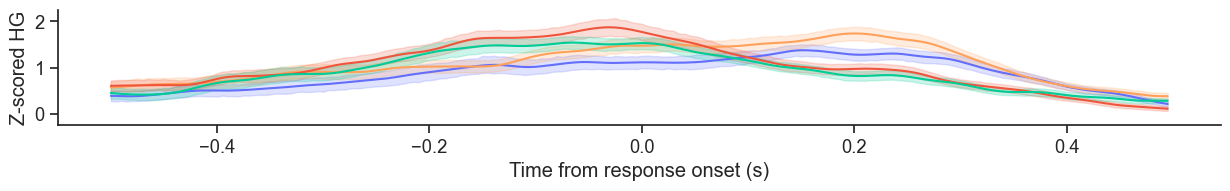

In [ ]:
fig_df = hg_artic_df_long[hg_artic_df_long['Patient'] == 'S1']

plt.figure(figsize=(15, 1.5))
g = sns.lineplot(data=fig_df, x='Time', y='Z-scored HG', hue='Articulator Type', palette=px_colors)
g.set_xlabel('Time from response onset (s)')
g.set_ylim([-0.25, 2.25])

sns.despine()
plt.legend([],[], frameon=False)
plt.show()


In [ ]:
pt = 'S26' # S2 in paper
pt_ind = pt_names.index(pt)
cnd_labels = all_pt_artic_labels[pt]; lab_names = artic_labels
data_avg = cnd_avg(all_pt_elec_data[pt_ind], cnd_labels)
chan_map = get_pt_map_from_flat(pt)

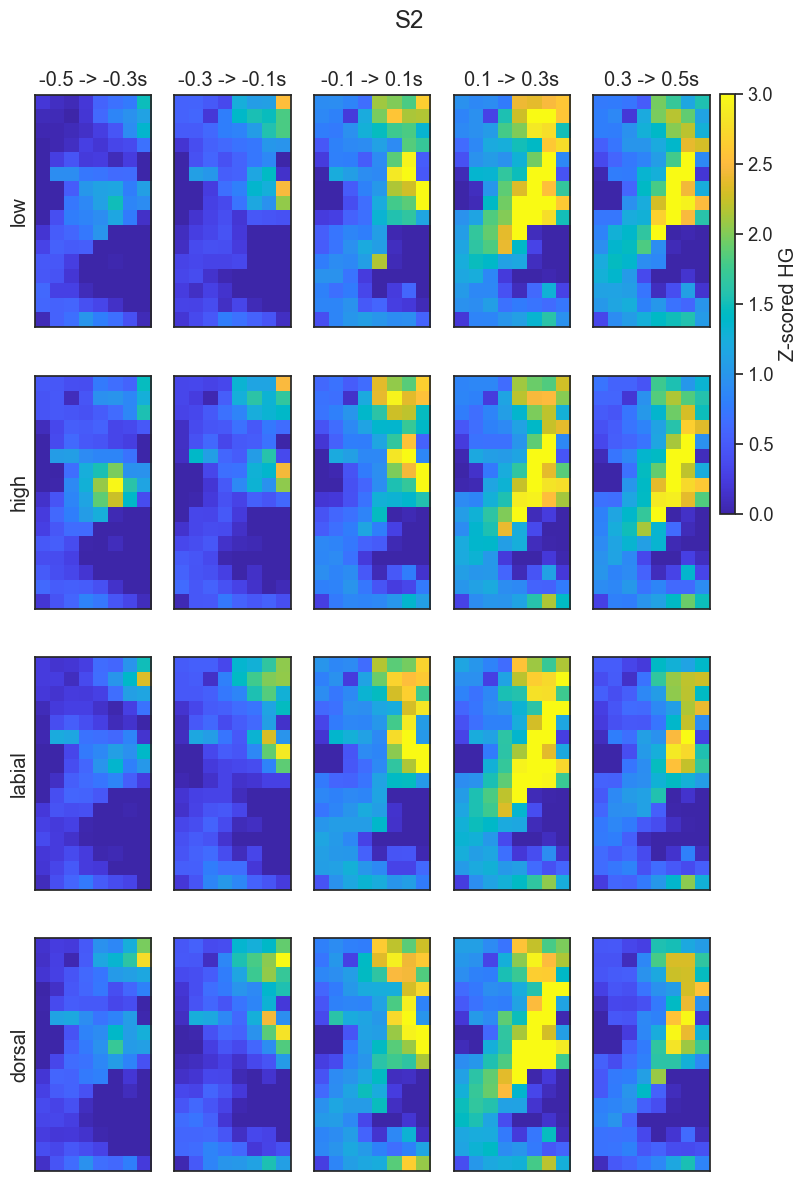

In [ ]:
t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

figsize=(2,3.5)
cbar_pos = [0.81, 0.58, 0.015, 0.3]
sup_pos = 0.94
chan_disp_seq(data_avg, chan_map, t, t_ranges, lab_names, 'S2', 'Z-scored HG', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos, cbar_lower=0, cbar_upper=3)

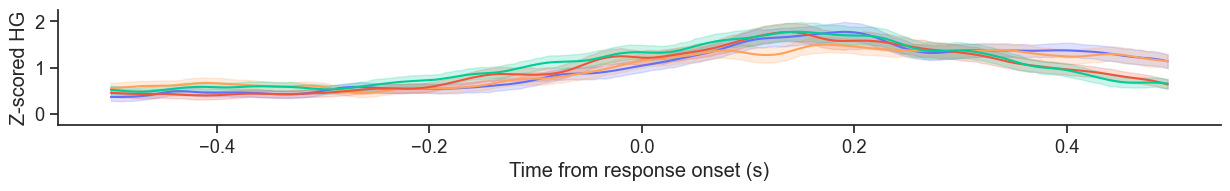

In [ ]:
fig_df = hg_artic_df_long[hg_artic_df_long['Patient'] == 'S2']

plt.figure(figsize=(15, 1.5))
g = sns.lineplot(data=fig_df, x='Time', y='Z-scored HG', hue='Articulator Type', palette=px_colors)
g.set_xlabel('Time from response onset (s)')
g.set_ylim([-0.25, 2.25])

sns.despine()
plt.legend([],[], frameon=False)
plt.show()

### Panel b

In [18]:
pt = 'S14'
curr_trace = all_pt_traces[pt]
curr_labels = all_pt_artic_labels[pt]
curr_label_names = artic_labels

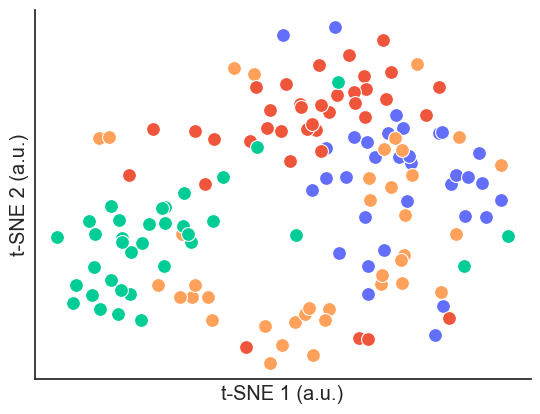

In [ ]:
t_pca_comp = 0.9
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(-1, curr_trace.shape[-1])).reshape(curr_trace.shape[0], -1)
pt_time_pca = PCA(n_components=50).fit_transform(pt_time_pca)
pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)

plt.figure()
for lab in np.unique(curr_labels):
    sns.scatterplot(x=pt_embed_time[np.where(curr_labels == lab)[0],1], y=-pt_embed_time[np.where(curr_labels == lab)[0],0], s=100)

plt.xlabel('t-SNE 1 (a.u.)')
plt.ylabel('t-SNE 2 (a.u.)')

frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])

sns.despine()
plt.show()

In [177]:
tsne_2d_data = []
for iTrial in range(pt_embed_time.shape[0]):
    tsne_dict = {'t-SNE 1': pt_embed_time[iTrial, 0], 't-SNE 2': -pt_embed_time[iTrial, 1], 'Articulatory Type': curr_label_names[curr_labels[iTrial]-1]}
    tsne_2d_data.append(tsne_dict)
tsne_2d_df = pd.DataFrame(tsne_2d_data)
tsne_2d_df

,t-SNE 1,t-SNE 2,Articulatory Type
0,0.396531,4.067564,dorsal
1,2.637050,-8.047057,dorsal
2,-1.165552,-9.303896,high
3,-3.055585,-5.707780,low
4,0.801660,-4.659584,low
...,...,...,...
139,4.459030,3.835755,dorsal
140,4.237061,-2.712624,high
141,-2.081830,-0.710808,labial
142,0.150148,-4.828534,high


In [ ]:
def get_cluster_scores(data, labels, scorer):
    return scorer(data, labels)

def silhouette_scorer(data, labels):
    # return average of positive silhouette scores
    sils = silhouette_samples(data, labels)
    sil_score = np.mean(sils[np.where(sils > 0)])
    return sil_score

In [98]:
t_range = [-0.5, 0.5]
t_idx = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
n_iter = 50
ps_clust_scores = []
ps_clust_scores_shuf = []

for i in tqdm(range(n_iter)):

    pt_time_pca_ld = PCA(n_components=t_pca_comp).fit_transform(curr_trace[:,t_idx,:].reshape(-1, curr_trace.shape[-1])).reshape(curr_trace.shape[0], -1)
    pt_time_pca = PCA(n_components=50).fit_transform(pt_time_pca)
    pt_embed_time_tsne = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
    pt_embed_time_pca = PCA(n_components=2).fit_transform(pt_time_pca)

    sil_score_tsne = get_cluster_scores(pt_embed_time_tsne, curr_labels, silhouette_scorer)
    sil_score_pca = get_cluster_scores(pt_embed_time_pca, curr_labels, silhouette_scorer)
    sil_score_pca_ld = get_cluster_scores(pt_time_pca_ld, curr_labels, silhouette_scorer)
    ch_score = get_cluster_scores(pt_time_pca_ld, curr_labels, calinski_harabasz_score)
    db_score = get_cluster_scores(pt_time_pca_ld, curr_labels, davies_bouldin_score)
    score_dict = {'Silhouette (t-SNE)': sil_score_tsne, 'Silhouette (PCA)': sil_score_pca, 'Silhouette (Lat. Dyn)': sil_score_pca_ld, 'Calinski-Harabasz': ch_score, 'Davies-Bouldin': db_score}
    ps_clust_scores.append(score_dict)

    shuf_labels = np.random.permutation(curr_labels)
    sil_score_tsne_shuf = get_cluster_scores(pt_embed_time_tsne, shuf_labels, silhouette_scorer)
    sil_score_pca_shuf = get_cluster_scores(pt_embed_time_pca, shuf_labels, silhouette_scorer)
    sil_score_pca_ld_shuf = get_cluster_scores(pt_time_pca_ld, shuf_labels, silhouette_scorer)
    ch_score_shuf = get_cluster_scores(pt_time_pca_ld, shuf_labels, calinski_harabasz_score)
    db_score_shuf = get_cluster_scores(pt_time_pca_ld, shuf_labels, davies_bouldin_score)
    shuf_dict = {'Silhouette (t-SNE)': sil_score_tsne_shuf, 'Silhouette (PCA)': sil_score_pca_shuf, 'Silhouette (Lat. Dyn)': sil_score_pca_ld_shuf, 'Calinski-Harabasz': ch_score_shuf, 'Davies-Bouldin': db_score_shuf}
    ps_clust_scores_shuf.append(shuf_dict)


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


In [ ]:
score_df_real = pd.DataFrame(ps_clust_scores)
score_df_shuf = pd.DataFrame(ps_clust_scores_shuf)
score_df_real['Condition'] = 'Articulatory Features'
score_df_shuf['Condition'] = 'Chance Distribution'
score_df = pd.concat([score_df_real, score_df_shuf], ignore_index=True)
score_df_long = score_df.melt(id_vars='Condition', var_name='Metric', value_name='Score')
ps_score_df = score_df[score_df['Condition'] == 'Articulatory Features']
score_df_long

,Condition,Metric,Score
0,Articulatory Features,Silhouette (t-SNE),0.315859
1,Articulatory Features,Silhouette (t-SNE),0.349333
2,Articulatory Features,Silhouette (t-SNE),0.337137
3,Articulatory Features,Silhouette (t-SNE),0.283278
4,Articulatory Features,Silhouette (t-SNE),0.341695
...,...,...,...
495,Chance Distribution,Davies-Bouldin,9.165468
496,Chance Distribution,Davies-Bouldin,9.578213
497,Chance Distribution,Davies-Bouldin,8.870372
498,Chance Distribution,Davies-Bouldin,8.784890


In [141]:
fig = px.box(score_df, color='Condition', y="Silhouette (t-SNE)", points='all', width=600, height=500, color_discrete_sequence=[px_colors[0], '#7F7F7F'])
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    font=dict(size=17, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    # title='Davies-Bouldin Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.01, 0.45],
)

fig.show()

In [146]:
ps_artic = score_df[score_df['Condition'] == 'Articulatory Features']['Silhouette (t-SNE)'].values
ps_chance = score_df[score_df['Condition'] == 'Chance Distribution']['Silhouette (t-SNE)'].values

res_ps = stats.mannwhitneyu(ps_artic, ps_chance, alternative='two-sided')
print(f'MWU: U = {res_ps.statistic}, p = {res_ps.pvalue}')
# res_ps = stats.ttest_1samp(ps_chance, ps_artic)
# print(f'T-test: t = {res_ps.statistic}, p = {res_ps.pvalue}')

MWU: U = 2500.0, p = 7.066071930388932e-18


### Panel c

In [272]:
wide_dfs = []
long_dfs = []
for pt in pt_names:
    n_comp = 0.9

    curr_trace = all_pt_traces[pt]
    curr_pca = PCA(n_components=n_comp).fit_transform(curr_trace.reshape(-1, curr_trace.shape[-1])).reshape(curr_trace.shape[0], curr_trace.shape[1], -1)

    d = curr_pca
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    unalgn_df_wide = pd.DataFrame(d, columns=[f'PC {i+1}' for i in range(d.shape[-1])])
    unalgn_df_wide['Time'] = np.tile(t, n_tr)
    unalgn_df_wide['Patient'] = [paper_pt_dict[pt]] * d.shape[0]
    unalgn_df_wide['Phoneme IDs'] = np.repeat(all_pt_phon_seqs_str[pt], t.shape[0])
    unalgn_df_wide['Vowel Sequence'] = unalgn_df_wide['Phoneme IDs'].apply(labels2cv)
    unalgn_df_wide['Phoneme Sequence'] = unalgn_df_wide['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    unalgn_df_wide['Articulator Sequence'] = unalgn_df_wide['Phoneme IDs'].apply(phon2artic_seq)

    unalgn_df_long = unalgn_df_wide.melt(id_vars=['Time', 'Patient', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='PC', value_name='Value')
    unalgn_df_long['PC'] = unalgn_df_long['PC'].apply(lambda x: int(x.split(' ')[-1]))
    
    wide_dfs.append(unalgn_df_wide)
    long_dfs.append(unalgn_df_long)

unalgn_df_wide = pd.concat(wide_dfs, ignore_index=True)
unalgn_df_long = pd.concat(long_dfs, ignore_index=True)

In [273]:
unalgn_df_wide

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 58,PC 59,PC 60,PC 61,PC 62,PC 63,PC 64,PC 65,PC 66,PC 67
0,-2.024448,1.094516,-0.488338,0.628861,-0.528684,0.847310,0.128835,0.558066,0.787708,0.419163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.203591,1.013278,-0.530105,0.599923,-0.549583,0.804297,0.051540,0.363235,0.670084,0.328733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.398940,0.905197,-0.574870,0.515646,-0.568206,0.722779,-0.027757,0.170598,0.571508,0.268142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.588752,0.778326,-0.606035,0.395776,-0.581074,0.621781,-0.088098,0.032309,0.502136,0.234808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.752075,0.653126,-0.598395,0.254790,-0.589994,0.500005,-0.118858,-0.078126,0.424224,0.202940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219195,2.156364,0.538008,-1.001617,-0.670586,-0.474570,0.617459,0.270964,0.674263,-0.732389,-0.101838,...,-0.462940,-0.230530,0.243952,-0.205760,0.054290,0.600553,0.035332,0.213956,0.122339,0.731079
219196,2.252653,0.600619,-1.006715,-0.485818,-0.593759,0.849121,0.345894,0.457519,-0.729127,-0.116138,...,-0.448477,-0.231072,0.266410,-0.162863,0.054542,0.624813,-0.010849,0.183598,0.077702,0.737251
219197,2.334182,0.641092,-1.036326,-0.290023,-0.685069,1.012470,0.431407,0.262598,-0.723850,-0.120630,...,-0.414304,-0.203775,0.296239,-0.127238,0.044731,0.632985,-0.063860,0.144170,0.028442,0.729300
219198,2.373623,0.651238,-1.058772,-0.094827,-0.740857,1.101963,0.527248,0.086648,-0.715129,-0.118131,...,-0.367125,-0.146474,0.316599,-0.104471,0.033322,0.620186,-0.119038,0.086192,-0.020249,0.713772


C:\Users\zms14\AppData\Local\Temp\ipykernel_39776\1878783780.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zms14\AppData\Local\Temp\ipykernel_39776\1878783780.py:8: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



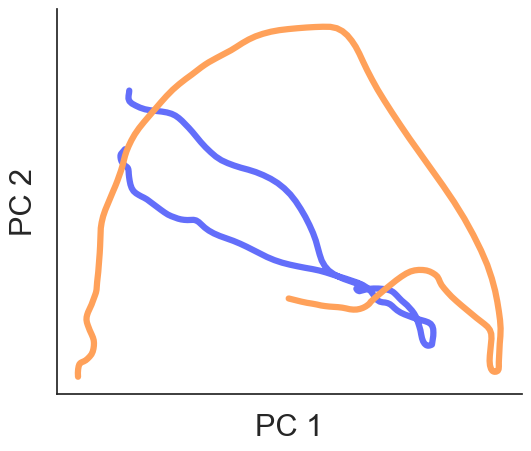

In [275]:
fig_df = unalgn_df_wide[unalgn_df_wide['Patient'].isin(['S1', 'S2'])]
fig_df['A1'] = fig_df['Articulator Sequence'].apply(lambda x: x.split('_')[0])
fig_df = fig_df.drop(columns=['Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence',  'A1']).groupby(['Time', 'Patient']).mean().reset_index()

f = plt.figure(figsize=(6, 5))
ax = f.add_subplot(111)
g = sns.lineplot(data=fig_df, x='PC 1', y='PC 2', hue='Patient', sort=False, linewidth=4.5, palette=px_colors, ax=ax)

sns.despine()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('PC 1', fontsize=22)
ax.set_ylabel('PC 2', fontsize=22)
ax.tick_params(left=False, bottom=False)
plt.legend([],[], frameon=False)

plt.show()

In [187]:
align_pt = 'S14'
align_pt_ind = pt_names.index(align_pt)

# setup CCA aligners for each condition and patient
aligners = {}
aligners_artic = {}
aligners_cv = {}
aligners_shuffle = {}
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    aligners[pt] = AlignCCA()
    aligners_shuffle[pt] = AlignCCA()
    aligners_artic[pt] = AlignCCA()
    aligners_cv[pt] = AlignCCA()

# get patient-specific latent dynamics with PCA on channels
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pt_names]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pt_names)]

# align patient-specific latent dynamics
aligned_data = {}
aligned_data_shuffle = {}
aligned_data_artic = {}
aligned_data_cv = {}

# aligning all patients to a single patient's space, so the align patient's latent dynamics are un-transformed
aligned_data[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_shuffle[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_artic[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_cv[pt_names[align_pt_ind]] = to_align[align_pt_ind]
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    
    # align by phoneme sequence
    to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
    aligners[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs[0], to_align_seqs[1])
    aligned_data[pt] = aligners[pt].transform(to_align[i])

    # align by shuffled phoneme sequence
    to_align_seqs_shuffle = [all_pt_phon_seqs[pt_names[align_pt_ind]], np.random.permutation(all_pt_phon_seqs[pt])]
    aligners_shuffle[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_shuffle[0], to_align_seqs_shuffle[1])
    aligned_data_shuffle[pt] = aligners_shuffle[pt].transform(to_align[i])

In [188]:
wide_dfs = []
long_dfs = []
for pt in pt_names:     
    d = aligned_data[pt]
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    algn_df_wide = pd.DataFrame(d, columns=[f'PC {i+1}' for i in range(d.shape[-1])])
    algn_df_wide['Time'] = np.tile(t, n_tr)
    algn_df_wide['Patient'] = [paper_pt_dict[pt]] * d.shape[0]
    algn_df_wide['Phoneme IDs'] = np.repeat(all_pt_phon_seqs_str[pt], t.shape[0])
    algn_df_wide['Vowel Sequence'] = algn_df_wide['Phoneme IDs'].apply(labels2cv)
    algn_df_wide['Phoneme Sequence'] = algn_df_wide['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    algn_df_wide['Articulator Sequence'] = algn_df_wide['Phoneme IDs'].apply(phon2artic_seq)

    algn_df_long = algn_df_wide.melt(id_vars=['Time', 'Patient', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='PC', value_name='Value')
    algn_df_long['PC'] = algn_df_long['PC'].apply(lambda x: int(x.split(' ')[-1]))
    
    wide_dfs.append(algn_df_wide)
    long_dfs.append(algn_df_long)

algn_df_wide = pd.concat(wide_dfs, ignore_index=True)
algn_df_long = pd.concat(long_dfs, ignore_index=True)

C:\Users\zms14\AppData\Local\Temp\ipykernel_39776\1561146860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zms14\AppData\Local\Temp\ipykernel_39776\1561146860.py:7: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



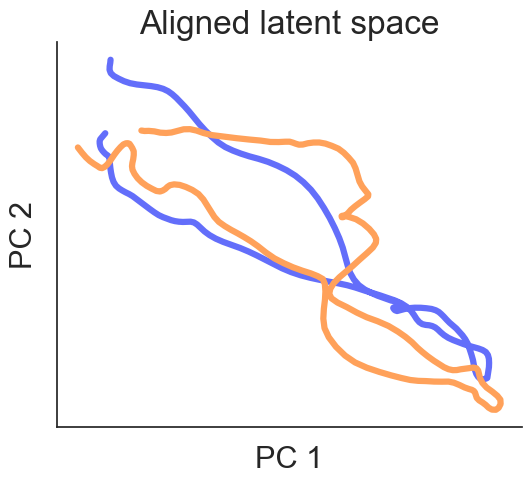

In [276]:
fig_df = algn_df_wide[algn_df_wide['Patient'].isin(['S1', 'S2'])]
fig_df['A1'] = fig_df['Articulator Sequence'].apply(lambda x: x.split('_')[0])
fig_df = fig_df.drop(columns=['Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence', 'A1']).groupby(['Time', 'Patient']).mean().reset_index()

f = plt.figure(figsize=(6, 5))
ax = f.add_subplot(111)
g = sns.lineplot(data=fig_df, x='PC 1', y='PC 2', hue='Patient', sort=False, linewidth=4.5, palette=px_colors, ax=ax)
sns.despine()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('PC 1', fontsize=22)
ax.set_ylabel('PC 2', fontsize=22)
ax.tick_params(left=False, bottom=False)
ax.set_title('Aligned latent space', fontsize=24)
plt.legend([],[], frameon=False)

plt.show()

### Panel d

In [ ]:
n_iter = 50
pts = ['S14', 'S26']

unalgn_scores = []
unalgn_scores_shuf = []
align_scores = []
align_scores_shuf = []
for i in tqdm(range(n_iter)):
    ### unaligned latent dynamics ###
    curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    min_dim = min(u.shape[-1] for u in curr_unalgn)
    curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
    curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

    unalgn_time_pca_ld = curr_unalgn.reshape(curr_unalgn.shape[0], -1)
    unalgn_time_pca = PCA(n_components=50).fit_transform(unalgn_time_pca_ld)
    unalgn_embed_time_tsne = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)
    unalgn_embed_time_pca = PCA(n_components=2).fit_transform(unalgn_time_pca)

    sil_score_tsne = get_cluster_scores(unalgn_embed_time_tsne, curr_unalgn_labels, silhouette_scorer)
    sil_score_pca = get_cluster_scores(unalgn_embed_time_pca, curr_unalgn_labels, silhouette_scorer)
    sil_score_pca_ld = get_cluster_scores(unalgn_time_pca_ld, curr_unalgn_labels, silhouette_scorer)
    ch_score = get_cluster_scores(unalgn_time_pca_ld, curr_unalgn_labels, calinski_harabasz_score)
    db_score = get_cluster_scores(unalgn_time_pca_ld, curr_unalgn_labels, davies_bouldin_score)
    score_dict = {'Silhouette (t-SNE)': sil_score_tsne, 'Silhouette (PCA)': sil_score_pca, 'Silhouette (Lat. Dyn)': sil_score_pca_ld, 'Calinski-Harabasz': ch_score, 'Davies-Bouldin': db_score}
    unalgn_scores.append(score_dict)

    shuf_labels = np.random.permutation(curr_unalgn_labels)
    sil_score_tsne_shuf = get_cluster_scores(unalgn_embed_time_tsne, shuf_labels, silhouette_scorer)
    sil_score_pca_shuf = get_cluster_scores(unalgn_embed_time_pca, shuf_labels, silhouette_scorer)
    sil_score_pca_ld_shuf = get_cluster_scores(unalgn_time_pca_ld, shuf_labels, silhouette_scorer)
    ch_score_shuf = get_cluster_scores(unalgn_time_pca_ld, shuf_labels, calinski_harabasz_score)
    db_score_shuf = get_cluster_scores(unalgn_time_pca_ld, shuf_labels, davies_bouldin_score)
    shuf_dict = {'Silhouette (t-SNE)': sil_score_tsne_shuf, 'Silhouette (PCA)': sil_score_pca_shuf, 'Silhouette (Lat. Dyn)': sil_score_pca_ld_shuf, 'Calinski-Harabasz': ch_score_shuf, 'Davies-Bouldin': db_score_shuf}
    unalgn_scores_shuf.append(shuf_dict)

    ### aligned latent dynamics ###
    aligner = AlignCCA()
    to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
    to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
    aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
    aligned_pt_data = aligner.transform(to_align[1])
    aligned_data = [to_align[0], aligned_pt_data]
    curr_algn = np.vstack(aligned_data)
    curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

    algn_time_pca_ld = curr_algn.reshape(curr_algn.shape[0], -1)
    algn_time_pca = PCA(n_components=50).fit_transform(algn_time_pca_ld)
    algn_embed_time_tsne = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
    algn_embed_time_pca = PCA(n_components=2).fit_transform(algn_time_pca)

    sil_score_tsne = get_cluster_scores(algn_embed_time_tsne, curr_algn_labels, silhouette_scorer)
    sil_score_pca = get_cluster_scores(algn_embed_time_pca, curr_algn_labels, silhouette_scorer)
    sil_score_pca_ld = get_cluster_scores(algn_time_pca_ld, curr_algn_labels, silhouette_scorer)
    ch_score = get_cluster_scores(algn_time_pca_ld, curr_algn_labels, calinski_harabasz_score)
    db_score = get_cluster_scores(algn_time_pca_ld, curr_algn_labels, davies_bouldin_score)
    score_dict = {'Silhouette (t-SNE)': sil_score_tsne, 'Silhouette (PCA)': sil_score_pca, 'Silhouette (Lat. Dyn)': sil_score_pca_ld, 'Calinski-Harabasz': ch_score, 'Davies-Bouldin': db_score}
    align_scores.append(score_dict)

    shuf_labels = np.random.permutation(curr_algn_labels)
    sil_score_tsne_shuf = get_cluster_scores(algn_embed_time_tsne, shuf_labels, silhouette_scorer)
    sil_score_pca_shuf = get_cluster_scores(algn_embed_time_pca, shuf_labels, silhouette_scorer)
    sil_score_pca_ld_shuf = get_cluster_scores(algn_time_pca_ld, shuf_labels, silhouette_scorer)
    ch_score_shuf = get_cluster_scores(algn_time_pca_ld, shuf_labels, calinski_harabasz_score)
    db_score_shuf = get_cluster_scores(algn_time_pca_ld, shuf_labels, davies_bouldin_score)
    shuf_dict = {'Silhouette (t-SNE)': sil_score_tsne_shuf, 'Silhouette (PCA)': sil_score_pca_shuf, 'Silhouette (Lat. Dyn)': sil_score_pca_ld_shuf, 'Calinski-Harabasz': ch_score_shuf, 'Davies-Bouldin': db_score_shuf}
    align_scores_shuf.append(shuf_dict)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [03:27<00:00,  4.14s/it]


In [154]:
unalgn_score_df = pd.DataFrame(unalgn_scores)
unalgn_score_df['Condition'] = 'Articulatory Features'
unalgn_score_df['Data'] = 'Unaligned'

unalgn_score_df_shuf = pd.DataFrame(unalgn_scores_shuf)
unalgn_score_df_shuf['Condition'] = 'Chance Distribution'
unalgn_score_df_shuf['Data'] = 'Unaligned'

algn_score_df = pd.DataFrame(align_scores)
algn_score_df['Condition'] = 'Articulatory Features'
algn_score_df['Data'] = 'Aligned'

algn_score_df_shuf = pd.DataFrame(align_scores_shuf)
algn_score_df_shuf['Condition'] = 'Chance Distribution'
algn_score_df_shuf['Data'] = 'Aligned'

cross_score_df = pd.concat([unalgn_score_df, unalgn_score_df_shuf, algn_score_df, algn_score_df_shuf], ignore_index=True)
cross_score_df

,Silhouette (t-SNE),Silhouette (PCA),Silhouette (Lat. Dyn),Calinski-Harabasz,Davies-Bouldin,Condition,Data
0,0.103973,0.122321,0.031497,4.889774,6.484440,Articulatory Features,Unaligned
1,0.085081,0.122321,0.031497,4.889774,6.484440,Articulatory Features,Unaligned
2,0.082654,0.122321,0.031497,4.889774,6.484440,Articulatory Features,Unaligned
3,0.107390,0.122321,0.031497,4.889774,6.484440,Articulatory Features,Unaligned
4,0.098856,0.122321,0.031497,4.889774,6.484440,Articulatory Features,Unaligned
...,...,...,...,...,...,...,...
195,0.022100,0.022617,0.005191,0.989545,13.029283,Chance Distribution,Aligned
196,0.039805,0.041514,0.010219,0.999476,12.562351,Chance Distribution,Aligned
197,0.060023,0.055631,0.007080,1.031820,12.901501,Chance Distribution,Aligned
198,0.036548,0.024487,0.006805,0.995462,12.478565,Chance Distribution,Aligned


In [ ]:
fig = px.box(cross_score_df, color='Condition', y="Silhouette (t-SNE)", x='Data', points='all', width=700, height=500, color_discrete_sequence=[px_colors[0], '#7F7F7F'])
fig.add_hline(y=ps_score_df['Silhouette (t-SNE)'].mean(), line_dash='dash', line_color='red')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    title_text=f'Clustering with CCA Alignment - {", ".join(pts)}',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.01, 0.4]
)

fig.show()

In [169]:
pvals = []

un_artic = cross_score_df[(cross_score_df['Condition'] == 'Articulatory Features') & (cross_score_df['Data'] == 'Unaligned')]['Silhouette (t-SNE)'].values
un_chance = cross_score_df[(cross_score_df['Condition'] == 'Chance Distribution') & (cross_score_df['Data'] == 'Unaligned')]['Silhouette (t-SNE)'].values

algn_artic = cross_score_df[(cross_score_df['Condition'] == 'Articulatory Features') & (cross_score_df['Data'] == 'Aligned')]['Silhouette (t-SNE)'].values
algn_chance = cross_score_df[(cross_score_df['Condition'] == 'Chance Distribution') & (cross_score_df['Data'] == 'Aligned')]['Silhouette (t-SNE)'].values

print('Unaligned: artic vs chance')
res_un_ac = stats.mannwhitneyu(un_artic, un_chance)
print(f'MWU: U = {res_un_ac.statistic}, p = {res_un_ac.pvalue}')

print('Aligned: artic vs chance')
res_algn_ac = stats.mannwhitneyu(algn_artic, algn_chance)
print(f'MWU: U = {res_algn_ac.statistic}, p = {res_algn_ac.pvalue}')

print('Aligned vs Unaligned')
res_un_algn = stats.mannwhitneyu(algn_artic, un_artic)
print(f'MWU: U = {res_un_algn.statistic}, p = {res_un_algn.pvalue}')


# correct for false comparisons
pvals = [res_un_ac.pvalue, res_algn_ac.pvalue, res_un_algn.pvalue]
p_vals_cor = fdrcorrection(pvals)[1]
print()
print('Corrected p-values')
print(p_vals_cor)

Unaligned: artic vs chance
MWU: U = 2438.0, p = 2.6913129710126445e-16
Aligned: artic vs chance
MWU: U = 2500.0, p = 7.066071930388932e-18
Aligned vs Unaligned
MWU: U = 2500.0, p = 7.066071930388932e-18

Corrected p-values
[2.69131297e-16 1.05991079e-17 1.05991079e-17]


### Panel e

In [78]:
align_pt = 'S14'
align_pt_ind = pt_names.index(align_pt)

# setup CCA aligners for each condition and patient
aligners = {}
aligners_artic = {}
aligners_cv = {}
aligners_shuffle = {}
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    aligners[pt] = AlignCCA()
    aligners_shuffle[pt] = AlignCCA()
    aligners_artic[pt] = AlignCCA()
    aligners_cv[pt] = AlignCCA()

# get patient-specific latent dynamics with PCA on channels
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pt_names]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pt_names)]

# align patient-specific latent dynamics
aligned_data = {}
aligned_data_shuffle = {}
aligned_data_artic = {}
aligned_data_cv = {}

# aligning all patients to a single patient's space, so the align patient's latent dynamics are un-transformed
aligned_data[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_shuffle[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_artic[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_cv[pt_names[align_pt_ind]] = to_align[align_pt_ind]
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    
    # align by phoneme sequence
    to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
    aligners[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs[0], to_align_seqs[1])
    aligned_data[pt] = aligners[pt].transform(to_align[i])

    # align by shuffled phoneme sequence
    to_align_seqs_shuffle = [all_pt_phon_seqs[pt_names[align_pt_ind]], np.random.permutation(all_pt_phon_seqs[pt])]
    aligners_shuffle[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_shuffle[0], to_align_seqs_shuffle[1])
    aligned_data_shuffle[pt] = aligners_shuffle[pt].transform(to_align[i])

In [79]:
def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25, t_range=[-0.25, 0.25]):
    min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
    # get data only around speech onset
    t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
    target = target[:, t_inds]
    to_corr = to_corr[:, t_inds]
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    n_cnds = cnd_avg_data[0].shape[0]
    cnd_r = np.zeros(n_cnds)
    for i in range(cnd_avg_data[0].shape[0]):
        target_avg = cnd_avg_data[0][i,:,:min_dim]
        to_corr_avg = cnd_avg_data[1][i,:,:min_dim]

        r_vals = np.zeros(min_dim)
        for j in range(min_dim):
            r_vals[j] = stats.pearsonr(target_avg[:,j], to_corr_avg[:,j])[0]
        cnd_r[i] = np.mean(r_vals)
    return cnd_r

def pt_corr_multi(target, to_corr_list, target_labels, to_corr_labels_list, n_comp=25, t_range=[-0.25, 0.25]):
    cnd_r = []
    for i, to_corr in enumerate(to_corr_list):
        cnd_r.append(pt_corr(target, to_corr, target_labels, to_corr_labels_list[i], n_comp=n_comp, t_range=t_range))
    return cnd_r

In [80]:
n_comp_corr = 10

other_pts = [pt for pt in pt_names if pt != align_pt]
unalign_corrs = pt_corr_multi(to_align[align_pt_ind], [to_align[pt_names.index(pt)] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
align_corrs = pt_corr_multi(aligned_data[align_pt], [aligned_data[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
shuff_corrs = pt_corr_multi(aligned_data_shuffle[align_pt], [aligned_data_shuffle[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)

In [81]:
# combine unaligned and aligned correlations in dataframe for plotting
corr_df = pd.DataFrame()
corr_df_mean = pd.DataFrame()
for i, pt in enumerate(other_pts):
    curr_pt = pt
    pt_unalign_corr = pd.DataFrame({'Correlation': unalign_corrs[i]})
    pt_unalign_corr['Condition'] = 'Unaligned'
    pt_unalign_corr['Patient'] = curr_pt

    pt_align_corr = pd.DataFrame({'Correlation': align_corrs[i]})
    pt_align_corr['Condition'] = 'Phoneme-aligned'
    pt_align_corr['Patient'] = curr_pt

    pt_align_corr_shuff = pd.DataFrame({'Correlation': shuff_corrs[i]})
    pt_align_corr_shuff['Condition'] = 'Aligned to S1 - Shuffled'
    pt_align_corr_shuff['Patient'] = curr_pt

    corr_df_mean = pd.concat([corr_df_mean, pd.DataFrame({'Correlation': [np.mean(unalign_corrs[i]), np.mean(align_corrs[i]), np.mean(shuff_corrs[i])],
                                                          'Condition': ['Unaligned', f'Aligned to S1', f'Aligned to S1 - Shuffled'],
                                                          'Patient': [curr_pt, curr_pt, curr_pt], 'Order': [0,1,2],})], ignore_index=True)
    corr_df = pd.concat([corr_df, pt_unalign_corr, pt_align_corr, pt_align_corr_shuff], ignore_index=True) 

corr_df_mean['Patient'] = corr_df_mean['Patient'].apply(lambda x: paper_pt_dict[x])
corr_df_mean = corr_df_mean.sort_values(by=['Patient', 'Order'])

In [82]:
corr_df_mean

,Correlation,Condition,Patient,Order
0,0.019181,Unaligned,S2,0
1,0.505732,Aligned to S1,S2,1
2,0.288690,Aligned to S1 - Shuffled,S2,2
6,0.035535,Unaligned,S3,0
7,0.506030,Aligned to S1,S3,1
8,0.372343,Aligned to S1 - Shuffled,S3,2
9,-0.001028,Unaligned,S4,0
10,0.348642,Aligned to S1,S4,1
11,0.225701,Aligned to S1 - Shuffled,S4,2
3,0.115434,Unaligned,S5,0


In [83]:
fig = px.line(corr_df_mean, x='Condition', y="Correlation", color='Patient', width=800, height=500, color_discrete_sequence=px.colors.qualitative.Plotly[1:])
fig.add_traces(px.box(corr_df_mean, x='Condition', y="Correlation").data)
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    title_text=f'Correlation with S1 Latent Dynamics',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.1, 0.65]
)

fig.show()

In [84]:
pvals = []

stat_df = corr_df_mean
un_corrs = stat_df[stat_df['Condition'] == 'Unaligned']['Correlation']
algn_corrs = stat_df[stat_df['Condition'] == 'Aligned to S1']['Correlation']
shuff_corrs = stat_df[stat_df['Condition'] == 'Aligned to S1 - Shuffled']['Correlation']

# test for significant difference between unaligned and aligned correlations
print('Unaligned vs. Aligned')

res_un_phon = stats.wilcoxon(un_corrs, algn_corrs)
print(f'Wilcoxon: statistic = {res_un_phon.statistic}, p = {res_un_phon.pvalue}')

# test for significant difference between unaligned and shuffled aligned correlations
print('Unaligned vs. Aligned Shuffled')
res_un_shuff = stats.wilcoxon(un_corrs, shuff_corrs)
print(f'Wilcoxon: statistic = {res_un_shuff.statistic}, p = {res_un_shuff.pvalue}')

# test for significant difference between aligned and shuffled aligned correlations
print('Aligned vs. Aligned Shuffled')
res_phon_shuff = stats.wilcoxon(algn_corrs, shuff_corrs)
print(f'Wilcoxon: statistic = {res_phon_shuff.statistic}, p = {res_phon_shuff.pvalue}')

# correct for false comparisons
pvals = [res_un_phon.pvalue, res_un_shuff.pvalue, res_phon_shuff.pvalue]
p_vals_cor = fdrcorrection(pvals)[1]
print()
print('Corrected p-values')
print(p_vals_cor)


Unaligned vs. Aligned
Wilcoxon: statistic = 0.0, p = 0.015625
Unaligned vs. Aligned Shuffled
Wilcoxon: statistic = 0.0, p = 0.015625
Aligned vs. Aligned Shuffled
Wilcoxon: statistic = 0.0, p = 0.015625

Corrected p-values
[0.015625 0.015625 0.015625]
